In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/kaggle/input/dont-overfit-ii/train.csv
/kaggle/input/dont-overfit-ii/sample_submission.csv
/kaggle/input/dont-overfit-ii/test.csv


In [2]:
import numpy as np
import pandas as pd
pd.set_option('max_columns', None)
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import datetime
import lightgbm as lgb
from scipy import stats
from sklearn.model_selection import train_test_split, StratifiedKFold, KFold, cross_val_score, GridSearchCV, RepeatedStratifiedKFold
from sklearn.preprocessing import StandardScaler
import os
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
import xgboost as xgb
import lightgbm as lgb
from sklearn import model_selection
from sklearn.metrics import accuracy_score, roc_auc_score
import json
import ast
import time
from sklearn import linear_model
import eli5
from eli5.sklearn import PermutationImportance
import shap

from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
from sklearn.neighbors import NearestNeighbors
from sklearn.feature_selection import GenericUnivariateSelect, SelectPercentile, SelectKBest, f_classif, mutual_info_classif, RFE
import statsmodels.api as sm
import warnings
warnings.filterwarnings('ignore')
from catboost import CatBoostClassifier

/opt/conda/lib/python3.6/site-packages/sklearn/externals/six.py:31: DeprecationWarning:

The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).

/opt/conda/lib/python3.6/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning:

sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.

Using TensorFlow backend.


## Loading Data

In [3]:
train = pd.read_csv('../input/dont-overfit-ii/train.csv')
test = pd.read_csv('../input/dont-overfit-ii/test.csv')
labels = train.columns.drop(['id', 'target'])
test_id=test['id']
test_features = test.drop(['id'],axis=1)
train.head()

,id,target,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299
0,0,1.0,-0.098,2.165,0.681,-0.614,1.309,-0.455,-0.236,0.276,-2.246,1.825,-0.912,-0.107,0.305,0.102,0.826,0.417,0.177,-0.673,-0.503,1.864,0.410,-1.927,0.102,-0.931,1.763,1.449,-1.097,-0.686,-0.250,-1.859,1.125,1.009,-2.296,0.385,-0.876,1.528,-0.144,-1.078,-0.403,0.005,1.405,-0.044,-0.458,0.579,2.929,0.833,0.761,0.737,0.669,0.717,-1.542,-1.847,-0.445,1.238,-0.840,-1.891,-1.531,-0.396,-0.927,2.072,0.946,-1.105,0.008,0.933,-1.410,-0.770,1.740,-1.504,-0.391,-1.551,-1.415,-0.974,0.796,-2.464,-1.424,1.230,0.219,0.130,-0.371,-0.930,1.851,1.292,-0.380,1.318,1.146,-0.399,2.227,0.447,0.870,1.420,-1.675,0.019,0.060,0.768,2.563,0.638,1.164,0.407,-1.556,-0.903,1.329,0.452,-0.704,2.218,-1.844,0.158,-1.649,-0.172,-1.167,-1.456,-0.778,0.098,-1.627,0.405,-0.082,-0.797,-0.303,0.710,-0.252,1.920,0.706,-0.915,0.267,-0.607,0.966,-0.337,-2.292,-1.366,-1.085,0.278,0.212,1.260,-1.276,-2.013,-1.101,0.797,0.661,1.232,-0.632,-0.805,1.236,-1.085,-0.067,-0.661,-0.745,1.306,-0.010,-0.475,-0.613,-0.841,-0.837,0.671,2.493,0.689,0.946,0.160,-0.607,-0.775,1.688,0.302,-1.156,-0.718,0.126,0.745,-0.287,-0.565,0.646,-0.119,-0.675,-0.479,-0.191,-0.454,1.314,0.740,0.999,1.242,-0.339,0.403,-1.243,1.365,0.030,-0.475,0.860,0.036,1.313,-0.219,1.078,1.880,-0.317,-0.443,1.876,-0.611,0.892,1.435,-0.226,0.311,0.139,-0.075,1.381,1.716,-2.017,-0.485,1.906,-0.119,0.609,-0.564,0.264,-0.604,-0.733,-2.352,-1.661,0.498,-0.841,0.907,-0.476,0.817,1.372,1.187,0.844,0.028,0.029,-0.808,0.253,1.005,1.413,-0.133,0.655,-0.921,0.231,-1.902,-0.005,-1.730,1.132,-0.194,0.039,1.489,-0.328,0.966,-0.057,-0.181,0.723,-0.313,-0.165,-0.803,0.074,-2.851,-1.021,-0.894,0.967,0.218,-0.692,-0.514,0.754,-1.892,0.203,2.174,-0.755,-1.053,-0.516,-1.109,-0.681,1.250,-0.565,-1.318,-0.923,0.075,-0.704,2.457,0.771,-0.460,0.569,-1.320,-1.516,-2.145,-1.120,0.156,0.820,-1.049,-1.125,0.484,0.617,1.253,1.248,0.504,-0.802,-0.896,-1.793,-0.284,-0.601,0.569,0.867,1.347,0.504,-0.649,0.672,-2.097,1.051,-0.414,1.038,-1.065
1,1,0.0,1.081,-0.973,-0.383,0.326,-0.428,0.317,1.172,0.352,0.004,-0.291,2.907,1.085,2.144,1.540,0.584,1.133,1.098,-0.237,-0.498,0.283,-1.100,-0.417,1.382,-0.515,-1.519,0.619,-0.128,0.866,-0.540,1.238,-0.227,0.269,-0.390,-2.721,1.659,0.106,-0.121,1.719,0.411,-0.303,-0.307,0.380,0.503,-1.320,0.339,-1.102,-0.947,0.267,0.695,0.167,0.188,-1.082,-0.872,0.660,0.051,0.303,-0.553,-0.771,0.588,0.472,1.315,-0.467,-0.064,1.808,0.633,1.221,1.112,1.133,-0.543,-2.144,0.151,-0.813,1.966,-1.190,0.190,-0.473,0.002,1.195,-0.799,1.117,-0.759,-0.661,0.406,-0.846,-0.035,-1.634,-0.011,0.503,0.610,-1.822,-0.030,1.188,-0.006,-0.279,1.914,0.620,-1.495,1.787,-0.305,0.602,-1.208,0.893,0.379,1.396,0.581,-0.475,-0.056,-0.691,-0.783,-1.485,1.911,-2.400,-2.372,-0.178,1.550,-0.228,0.674,0.987,1.373,-0.373,0.629,0.229,-0.630,-0.175,0.548,0.074,-2.090,-0.625,-1.131,1.111,-0.100,0.574,-0.660,-1.113,0.802,-0.093,1.302,-0.395,0.745,-0.384,0.066,-0.756,0.495,-0.8

In [4]:
test.head()

,id,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299
0,250,0.500,-1.033,-1.595,0.309,-0.714,0.502,0.535,-0.129,-0.687,1.291,0.507,-0.317,1.848,-0.232,-0.340,-0.051,0.804,0.764,1.860,0.262,1.112,-0.491,-1.039,-0.492,0.183,-0.671,-1.313,0.149,0.244,1.072,-1.003,0.832,-1.075,1.988,1.201,-2.065,-0.826,-0.016,0.490,0.191,0.732,1.235,-0.867,-0.616,0.340,0.788,-0.044,0.305,-0.819,-0.447,-1.625,-1.005,-0.653,-0.371,1.556,0.754,-0.688,0.061,0.644,0.645,-0.222,-2.174,-0.610,-1.092,0.917,-1.010,-1.021,-0.179,1.732,-0.366,-1.694,1.038,-0.721,0.112,-0.783,0.940,-1.803,1.295,-1.031,0.452,1.198,-0.206,0.051,-1.055,1.740,-0.910,-0.509,-0.987,-1.011,0.718,0.375,0.101,0.137,-1.585,0.532,-1.201,1.210,-0.374,0.300,-0.110,-0.248,1.464,0.056,-0.038,-0.482,0.585,-1.263,0.993,-0.639,-1.337,0.225,1.640,-1.807,-1.983,-0.638,-0.432,1.890,0.506,1.091,-0.635,1.072,0.262,0.418,-1.294,0.868,0.728,0.618,0.540,1.981,-0.246,0.516,-0.373,0.954,-0.854,-1.241,-0.861,0.317,-0.611,-0.179,-1.658,-1.397,-0.988,-0.316,1.808,0.930,1.098,0.997,0.901,1.095,-0.464,2.592,0.846,1.060,-0.676,0.376,0.047,1.265,1.218,1.003,1.219,-0.624,-1.316,0.921,3.472,-1.123,0.037,0.927,-0.695,-0.046,0.270,0.847,-1.072,0.315,2.522,0.376,-0.015,-1.283,-0.650,-0.106,0.747,0.612,-0.838,0.713,0.048,-1.073,0.657,-0.542,-0.269,-0.482,0.329,0.534,0.337,0.118,-0.164,-0.538,-0.285,1.375,1.194,-0.258,-0.298,1.578,-0.488,1.424,1.106,0.363,-2.007,-0.091,0.551,0.388,0.422,0.099,0.378,-1.333,-1.102,2.145,0.745,0.345,-0.904,0.425,-0.273,0.547,-0.184,0.458,0.182,0.592,0.966,0.540,-1.382,0.069,0.131,-0.068,-0.400,0.413,-0.030,0.890,1.000,-0.774,0.340,2.345,2.748,0.774,-0.355,0.574,0.027,1.437,-0.877,0.532,-0.348,0.926,1.308,-0.120,-1.460,0.755,0.426,1.667,-0.264,1.266,0.962,1.285,1.176,0.824,0.928,1.372,1.505,0.645,0.641,-1.132,1.009,0.998,0.210,-1.634,1.046,0.114,-0.806,0.301,0.145,-0.684,0.794,-0.290,-1.688,0.313,1.140,0.447,-0.616,1.294,0.785,0.453,1.550,-0.866,1.007,-0.088,-2.628,-0.845,2.078,-0.277,2.132,0.609,-0.104,0.312,0.979
1,251,0.776,0.914,-0.494,1.347,-0.867,0.480,0.578,-0.313,0.203,1.356,-1.086,0.322,0.876,-0.563,-1.394,0.385,1.891,-2.107,-0.636,-0.055,-0.843,0.041,0.253,0.557,0.475,-0.839,-1.146,1.210,1.427,0.347,1.077,-0.194,0.323,0.543,0.894,1.190,0.342,-0.858,0.756,1.350,-0.414,0.748,2.014,0.858,0.025,1.343,0.784,-0.418,-0.515,0.694,-1.097,0.559,-0.799,-0.936,1.483,1.670,1.403,0.457,-1.564,0.049,0.550,-0.085,-0.561,-0.529,-1.563,-0.781,-0.532,0.375,-0.727,-0.053,-0.383,-0.123,1.573,-0.898,-0.070,0.811,-0.036,0.720,1.691,-0.673,-0.421,-1.665,0.099,0.089,2.032,-1.132,-1.827,-0.017,-1.748,-0.717,2.004,1.216,1.547,1.322,0.481,1.819,-0.809,0.617,-0.763,-0.154,-0.847,-0.981,0.274,-1.856,0.808,-0.599,0.998,-0.286,0.649,0.612,-1.002,1.258,0.149,0.252,1.093,-0.344,0.349,-1.386,-0.518,1.478,-1.261,2.206,-0.053,-1.191,-1.118,0.402,0.786,-0.345,-0.387,0.558,2.202,-2.056,1.502,1.191,-0.404,-2.183,1.559,1.077,-0.659,0.339,1.113,0.286,-0.424,-1.061,-0.748,-1.148,1.705,1.239,-0.912,-0

## EDA

In [5]:
print("Train Shape: " , train.shape , "\nTest Shape:" , test.shape)

Train Shape:  (250, 302) 
Test Shape: (19750, 301)


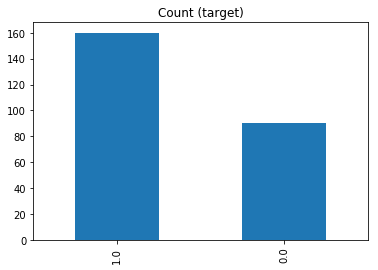

In [6]:
train['target'].value_counts().plot(kind='bar', title='Count (target)')

Text(0.5, 1.0, 'Distribution of the Standard Deviations of the Features')

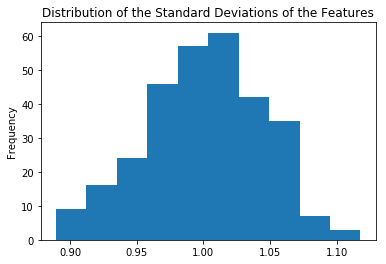

In [7]:
train[train.columns[2:]].std().plot('hist')
plt.title('Distribution of the Standard Deviations of the Features')

Text(0.5, 1.0, 'Distribution of the Means of the Features')

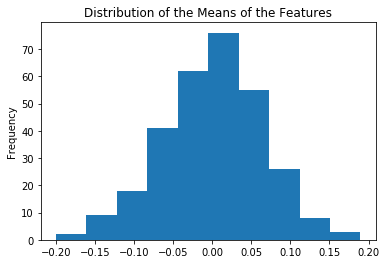

In [8]:
train[train.columns[2:]].mean().plot('hist')
plt.title('Distribution of the Means of the Features')

Distributions of the first 28 columns


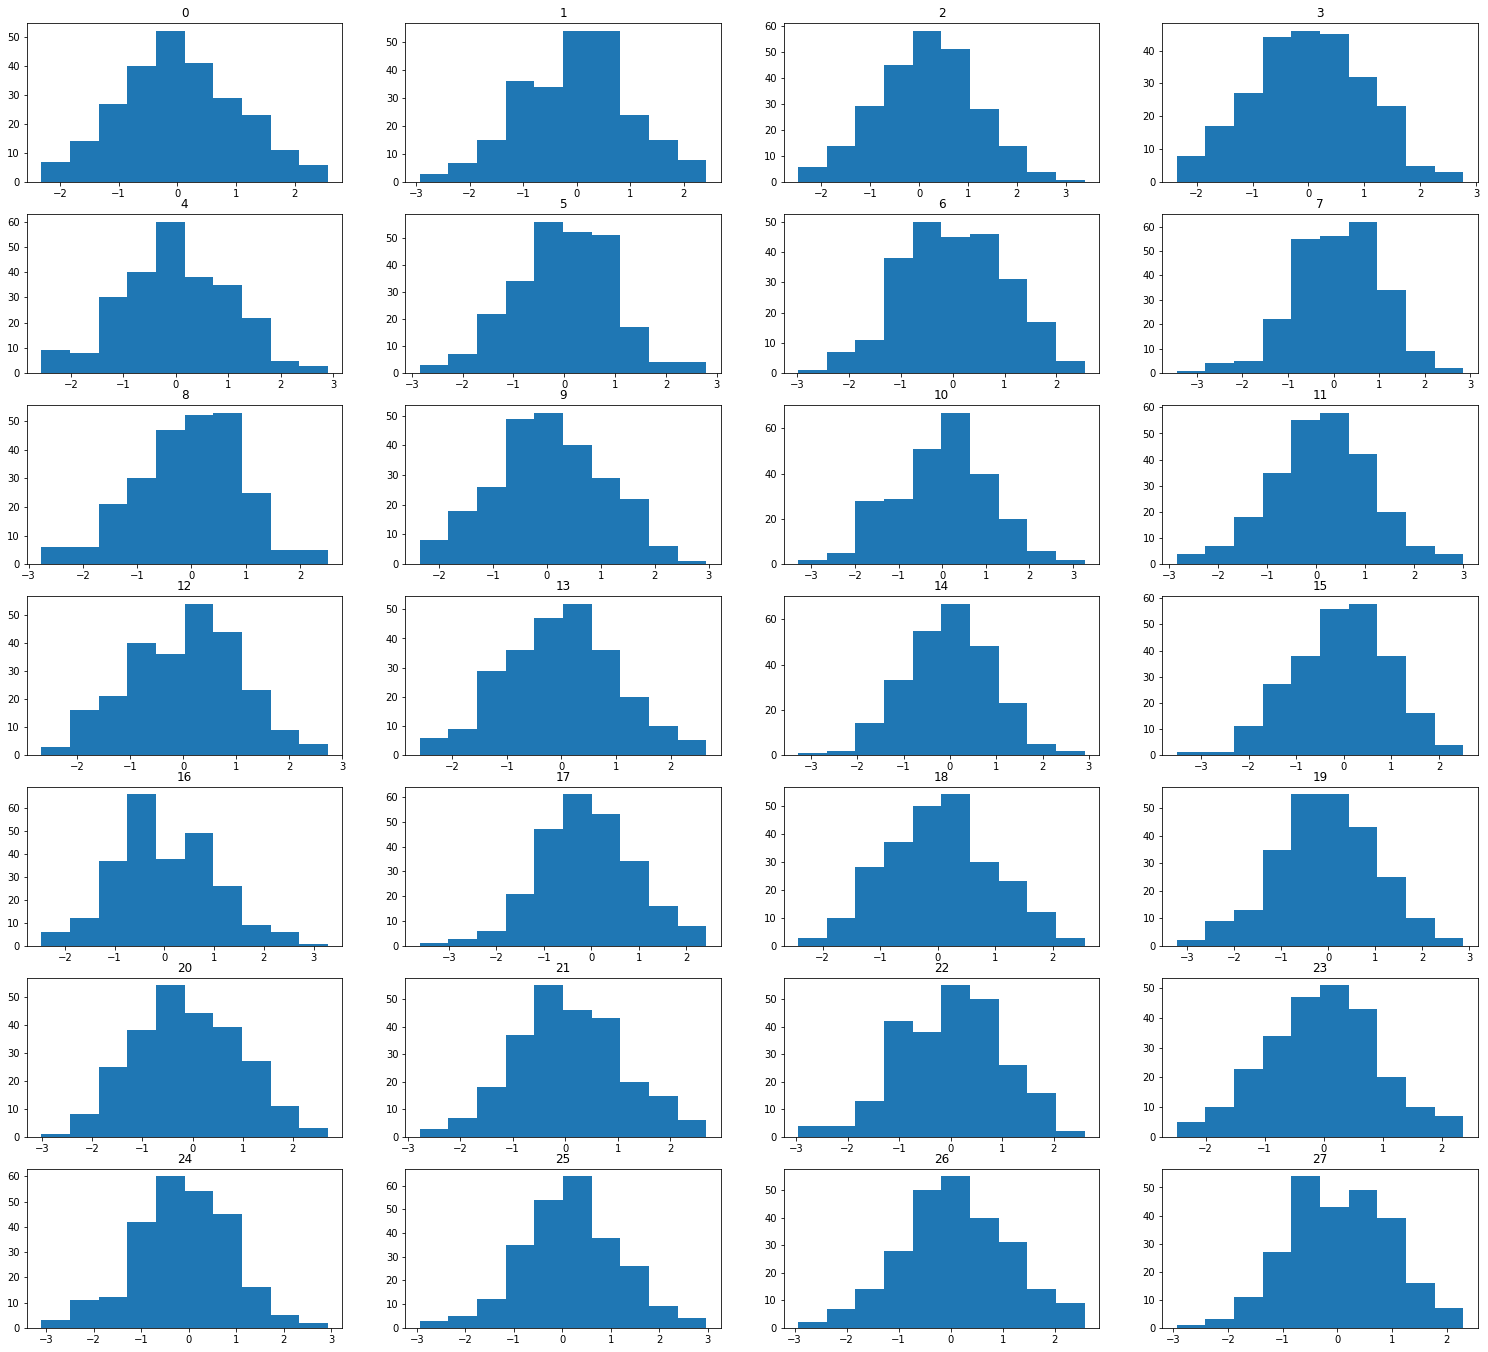

In [9]:
print('Distributions of the first 28 columns')
plt.figure(figsize=(26,24))
for i, col in enumerate(list(train.columns)[2:30]):
    plt.subplot(7,4,i+1)
    plt.hist(train[col])
    plt.title(col)

## Modeling

In [10]:
X_train = train.drop(['id','target'], axis=1)
y_train = train['target']
X_test = test.drop(['id'], axis=1)

In [11]:
from imblearn.over_sampling import SMOTE
smote = SMOTE(ratio='minority', n_jobs=-1)
X_sm, y_sm = smote.fit_resample(X_train, y_train)
#outputs X_sm and y_sm as ndarrays, need to convert back to df
X_train = pd.DataFrame(X_sm, columns=labels)
y_train = pd.DataFrame(y_sm, columns=['target'])

In [12]:
cols = X_train.columns
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_train = pd.DataFrame(X_train, columns = cols)
X = X_train
y = y_train

X_test = scaler.transform(X_test)
X_test = pd.DataFrame(X_test, columns = cols)

In [13]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=0)

Text(0.5, 1.0, 'Count of y_train target variable after SMOTE')

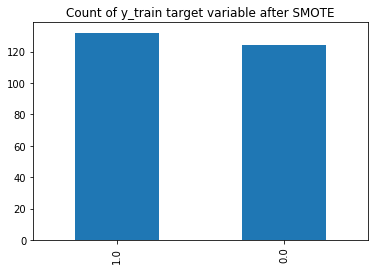

In [14]:
y_t = pd.Series(y_train.iloc[:,0], name="training")
y_t.value_counts().plot('bar')
plt.title('Count of y_train target variable after SMOTE')

In [15]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import ShuffleSplit, GridSearchCV
from sklearn.metrics import log_loss

In [16]:
cv_sets = ShuffleSplit(n_splits=10, test_size=0.2, random_state=0)
classifiers = [RandomForestClassifier(), SVC(), KNeighborsClassifier()]
params = [{'n_estimators': [3, 10,30]},
         {'kernel':('linear','poly','sigmoid','rbf'), 'C':[0.01,0.05,0.025,0.07,0.09,1.0], 'gamma':['scale'], 'probability':[True]},
         {'n_neighbors': [3,5,7,9]}]

In [17]:
best_estimators = []
for classifier, param in zip(classifiers,params):
    grid = GridSearchCV(classifier,param,cv=cv_sets)
    grid = grid.fit(X_train,y_train)
    best_estimators.append(grid.best_estimator_)

In [18]:
for estimator in best_estimators:
    estimator.fit(X_train, y_train)
    name = estimator.__class__.__name__
    
    print("="*30)
    print(name)
    
    print('****Results****')
    print('**Training set**')
    train_predictions = estimator.predict(X_train)
    acc = accuracy_score(y_train, train_predictions)
    print("Accuracy: {:.4%}".format(acc))
    train_predictions = estimator.predict_proba(X_train)
    ll = log_loss(y_train, train_predictions)
    print("Log Loss: {}".format(ll))
    
    print('**Validation set**')
    train_predictions = estimator.predict(X_val)
    acc = accuracy_score(y_val, train_predictions)
    print("Accuracy: {:.4%}".format(acc))
    train_predictions = estimator.predict_proba(X_val)
    ll = log_loss(y_val, train_predictions)
    print("Log Loss: {}".format(ll))
    
print("="*30)

RandomForestClassifier
****Results****
**Training set**
Accuracy: 100.0000%
Log Loss: 0.15980461812097577
**Validation set**
Accuracy: 75.0000%
Log Loss: 0.5409051820681914
SVC
****Results****
**Training set**
Accuracy: 100.0000%
Log Loss: 0.011954579217881876
**Validation set**
Accuracy: 84.3750%
Log Loss: 0.32986061472375483
KNeighborsClassifier
****Results****
**Training set**
Accuracy: 48.4375%
Log Loss: 0.5664719613444946
**Validation set**
Accuracy: 56.2500%
Log Loss: 15.110714672773424


In [19]:
pred = best_estimators[1].predict(X_test)

In [20]:
submission = pd.DataFrame(pred, index = test_id, columns=['target'])

In [21]:
submission

,target
id,
250,1.0
251,1.0
252,1.0
253,1.0
254,1.0
...,...
19995,1.0
19996,1.0
19997,1.0


In [22]:
submission['target']=submission['target'].astype('int64')

In [23]:
submission.to_csv('submission.csv', index=False)